# Introduction

In the following notebook, I will be analyzing patient data from the UCI Heart Disease [Dataset](https://archive.ics.uci.edu/ml/datasets/heart+disease). This dataset contains heart health information of patients diagnosed with/without heart disease. 

Note: This dataset originally had 75 attributes. Due to data corruption issues, only 14 attributes remain. 

In this notebook, I will be performing the following:
- Feature engineering to optimize data for machine learning classifiers
- Feature selection utilizing a Random Forest classifier to select the most informative features to maximize model performances
- Selecting an optimal classifier by constructing a pipeline that tests accuracy of each model on training data
- Model optimization using RandomSearchCV and evaluating model performance using Recall
- Manipulating decision threshold of optimized model to further increase model recall performance 
- Utilizing Stratified K-folds cross validation to evaluate model performance on training and test data
- Conclude analysis with a discussion about my findings and final takeaways from the project


Let's begin.

**Load Libraries and Read in Data**

In [689]:
#Read in Libraries
import pandas_profiling
import pandas as pd

import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

#Import warning filters
import warnings

#Ignore future and deprecation warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

#Set plot style for notebook
sns.set(style="whitegrid")

In [690]:
#Read in Data
df = pd.read_csv("heart.csv")

# Data Preview

**Variable Description**

UCI and Kaggle datasets reflect incorrect variable information, utilizing data dictionary corrections provided [here](https://www.kaggle.com/ronitf/heart-disease-uci/discussion/105877#latest-650005).

 age: The person's age in years

 sex: The person's sex (1 = male, 0 = female)

 cp: The chest pain experienced (Value 0: asymptomatic, Value 1: atypical angina,Value 2: non-anginal pain, Value 3: typical angina)

 trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)

 chol: The person's cholesterol measurement in mg/dl

 fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)

 restecg: Resting electrocardiographic measurement (0 = showing probable or definite left ventricular hypertrophy by Estes' criteria,  1 = normal,  2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))

 thalach: The person's maximum heart rate achieved

 exang: Exercise induced angina (1 = yes; 0 = no)

 oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot)

 slope: slope: the slope of the peak exercise ST segment (0 = downsloping,  1 = flat,  2 = upsloping)

 ca: The number of major vessels (0-3)

 thal: Thallium, a radioactive tracer injected during a stress test to evaluate myocardial cells (1 = fixed defect, 2 = normal, 3 = reversable defect)

 target: Heart disease (0 = disease, 1 = no disease)

**Pandas Profile Report**

In [691]:
#Create Pandas Profiling Report
#profile = df.profile_report(title='Pandas Profiling Report')

#Print Report
#profile

#Create html file of Profile Report for reference
#profile.to_file(output_file="Heart Disease Pandas Report.html")

# Data Cleaning

Remove duplicate rows

In [692]:
#Drop duplicate rows
df.drop_duplicates(inplace = True)

Remove rows containing anomalies in **ca** and **thal** columns(reference histograms in Pandas Report and data dictionary)

In [693]:
#Remove ca anomalies
df.drop(df[df['ca'] == 4].index, inplace=True)

#Remove thal anomalies
df.drop(df[df['thal'] == 0].index, inplace=True)

Update column headers with more informative names

In [694]:
#New column names
names= ['Age', 'Sex', 'Chest_Pain', 'Rest_BP', 'Cholesterol', 'FBS_Over_120mg/dl',
        'Rest_EKG', 'Max_HR', 'Exercise_Induced_Angina','ST_Depression', 
        'ST_Slope', 'Num_Major_Vessels', 'Thallium', 'Target']

#Assign names to df
df.columns = names

Due to data corruption issues, updating categorical values in the dataset as defined by updated [data dictionary](https://www.kaggle.com/ronitf/heart-disease-uci/discussion/105877#latest-650005).

Also updating the Target such that 1 indicates a patient with heart disease and 0 indicates a patient without heart disease. 

In [695]:
#Update Chest_Pain
df.loc[df['Chest_Pain'] == 0, 'Chest_Pain'] = 'Asymptomatic'
df.loc[df['Chest_Pain'] == 1, 'Chest_Pain'] = 'Atypical Angina'
df.loc[df['Chest_Pain'] == 2, 'Chest_Pain'] = 'Non-anginal Pain'
df.loc[df['Chest_Pain'] == 3, 'Chest_Pain'] = 'Typical Angina'


#Update Resting_ECG
df.loc[df['Rest_EKG'] == 0, 'Rest_EKG'] = 'Left ventricular hypertrophy'
df.loc[df['Rest_EKG'] == 1, 'Rest_EKG'] = 'Normal'
df.loc[df['Rest_EKG'] == 2, 'Rest_EKG'] = 'ST-T wave abnormality'


#Update ST_Slope
df.loc[df['ST_Slope'] == 0, 'ST_Slope'] = 'Downsloping'
df.loc[df['ST_Slope'] == 1, 'ST_Slope'] = 'Flat'
df.loc[df['ST_Slope'] == 2, 'ST_Slope'] = 'Upsloping'


#Update Thalassemia
df.loc[df['Thallium'] == 1, 'Thallium'] = 'Fixed defect'
df.loc[df['Thallium'] == 2, 'Thallium'] = 'Normal'
df.loc[df['Thallium'] == 3, 'Thallium'] = 'Reversable defect'

#Update Sex
df.Sex = df.Sex.apply(lambda x: 'Male' if x ==1 else 'Female')

#Update Target 
df.Target = df.Target.apply(lambda x: 0 if x == 1 else 1)

# Exploratory Data Analysis

When it comes to heart disease, some attributes of interest immediately jump out. Sex (men are generally more prone to heart disease than women), cholesterol, and blood pressure have been advertised as significant contributors to heart disease by media advertising different heart medications. Let's see if that is the case within out dataset.

**Rates of Heart Disease between Men and Women**



Heart Disease counts by gender:
Sex     Target
Female  0          71
        1          24
Male    0          89
        1         112
Name: Target, dtype: int64

Heart Disease Visualization:


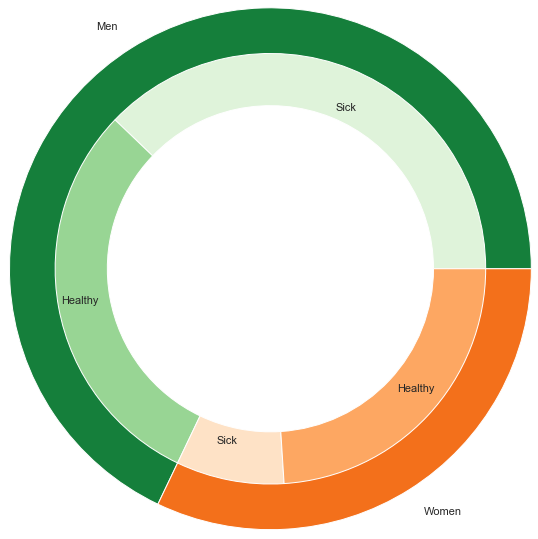

In [696]:
#Print target labels by sex
print('Heart Disease counts by gender:')
print(df.groupby(['Sex','Target'])['Target'].size(),end='\n\n')

#Print 
print('Heart Disease Visualization:')

#Make data for donut plot w/ 2 groups(sex) with 2 subgroups(sick/healthy) each.
group_names=['Men', 'Women']
subgroup_names=['Sick', 'Healthy', 'Sick', 'Healthy']

#Assign group/subgroup values based on target labels
group_size=[201,95]
subgroup_size=[112,89,24,71]
 
#Create colors
Men, Women =[plt.cm.Greens, plt.cm.Oranges]

#Set plot
fig, ax = plt.subplots(figsize=(6,6))

#Outter Ring
mypie, _ = ax.pie(group_size, radius=2, labels=group_names,frame=True, colors=[Men(.8), Women(0.6)])
plt.setp(mypie, width=0.6, edgecolor='white')
 
#Inner Ring
mypie2, _ = ax.pie(subgroup_size, radius=2-0.35, labels=subgroup_names, 
                   labeldistance=0.81, rotatelabels =0,
                   colors=[Men(0.15), Men(0.4), Women(0.15), Women(0.4)])
plt.setp(mypie2, width=0.4, edgecolor='white')

#Show
plt.show();

In our dataset, men outnumber women by quite a bit. However, the proportion of sick to healthy individuals between the sexes is very interesting but not super surprising. We do know that men are more likely to suffer from heart related illnesses that women ([source](https://www.telegraph.co.uk/men/active/mens-health/11723374/Why-do-men-suffer-more-heart-problems-than-women.html)).

Let's take a look into how a patient's resting BP correlates with rates of heart disease between men and women.

**Resting BP and Rates of Heart Disease by Gender**

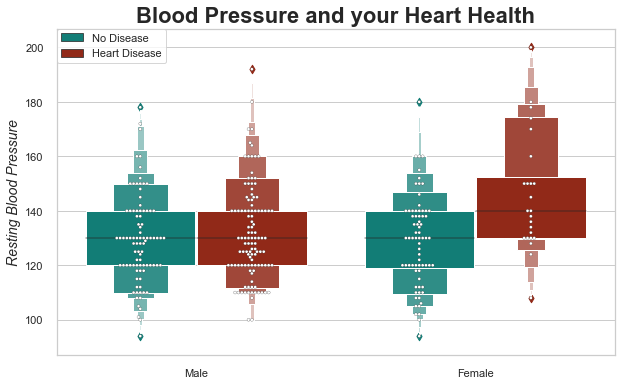

In [697]:
#Set Figure Size
fig, ax = plt.subplots(figsize = (10,6))

#Palette color for Target
disease=['#008F85','#A51A04']

#Create boxenplot
g = sns.boxenplot(x='Sex', y='Rest_BP', hue = 'Target', palette=disease,
                  dodge=True, data = df, ax=ax)

# Add raw observations
sns.swarmplot(x="Sex", y="Rest_BP", hue ='Target', data=df,dodge=True,
              size=3, palette=['#ffffff'], edgecolor='black', linewidth=.2)

#Set xlabel
g.set_xlabel('')

#Set ylabel
g.set_ylabel('Resting Blood Pressure', fontsize = 14, style='italic')

#Set title
g.set_title('Blood Pressure and your Heart Health', fontweight = 'heavy', family = 'sans-serif',fontsize = 22)

#Set Legend Labels. Get the handles and labels from boxemplot
handles, labels = g.get_legend_handles_labels()
labels = ['No Disease', 'Heart Disease']

#Create legend
l = g.legend(handles[0:2], labels[0:2],  loc='best', borderaxespad=0., frameon=True)

Interestingly enough, women with a higher resting blood pressure are more prone to having heart disease than men in this dataset. In fact, aside from a few outliers, blood pressure does not to have a significant effect on heart disease. 

Let's take a peek at our patient cholesterol levels. We'll take a look at the cholesterol level distributions for healthy and sick patients

**Cholesterol Distributions**

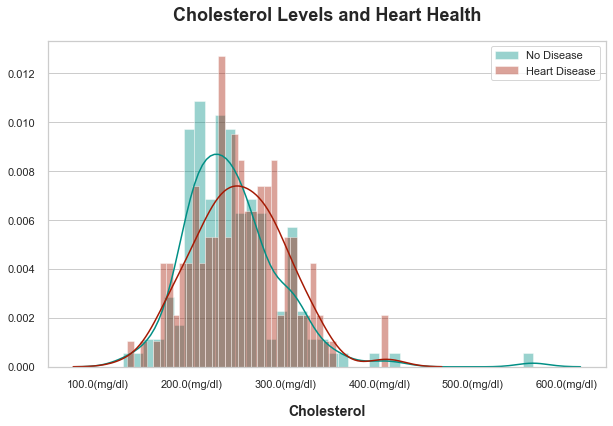

In [698]:
#Set figure size
fig, ax = plt.subplots(figsize = (10,6))

#Plot histogram of cholesterol for healthy patients
g = sns.distplot(df['Cholesterol'][df['Target'] == 0], bins = 40, label='No Disease',
                 color = '#008F85', ax=ax)

#Plot histogram of cholesterol for sick patients
k=sns.distplot(df['Cholesterol'][df['Target'] == 1], bins=40, label='Heart Disease',
               color = '#A51A04', ax=ax)

#Set X-axis label
g.set_xlabel('Cholesterol', fontweight='bold', fontsize=14, labelpad=15 )

#Format x-ticks
xlabels = [format(x) + '(mg/dl)' for x in g.get_xticks()]
g.set_xticklabels(xlabels)

#Set Title
g.set_title('Cholesterol Levels and Heart Health',fontweight='bold', fontsize=18, pad = 20)

#Mute vertical grid lines
ax.xaxis.grid()

#Show Legend
plt.legend(frameon=True, loc = 'best');

What is cholesterol?

Cholesterol is an organic molecule biosynthesized by all animal cells and is an essential structural component of animal cell membranes. 

When there is too much cholesterol in your blood, it builds up in the walls of your arteries, causing a process called atherosclerosis (a form of heart disease). As the arteries become narrowed, blood flow to the heart muscle slows and can become blocked, increasing the risk of a heart attack.

In our dataset, on average those with heart disease did have a higher cholesterol than healthy patient. It is curious to see that there are a few healthy patients with very high cholesterol levels (perhaps indicating a future heart disease diagnosis).

Let's now explore some of the features related directly to the heart. We will look into the reported chest pains of the patient, the presence of Thallium, as well as the ST slope of the patient observed during their EKG.

**Chest pain Diagnosis and Heart Disease**

What do these Chest Pain Diagnoses mean?

Chest pain is a well-established sign of a heart attack; however, it can also indicate many other less serious conditions.

- Asymptomatic: neither causing nor exhibiting symptoms of disease
- Non-anginal Pain: Non-cardiac chest pain is the term that is used to describe pain in the chest that is not caused by heart disease or a heart attack
- Typical Angina: discomfort when the heart does not get enough blood or oxygen. Symptoms are generally stable and patients can predict when pain will occur based upon level of activity. Pain subsides after rest
- Atypical Angina: Medical emergency, more intensive chest pain than typical anginal pain and does not resolve when patient rests. Patient is more likely to suffer a heart attack.

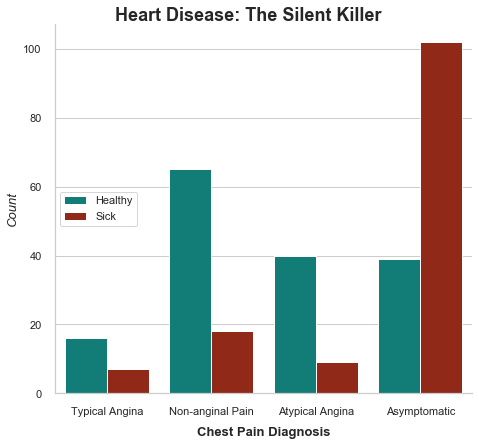

In [699]:
#Plot
g = sns.catplot(x='Chest_Pain', hue='Target', height=6, aspect=1.1,
                palette=disease,legend_out=False,
            kind = 'count',data=df)

#Set x label
g.axes[0,0].set_xlabel('Chest Pain Diagnosis', fontsize=13, fontweight='bold', labelpad=10)

#Set ylabel
g.axes[0,0].set_ylabel('Count', fontsize=13, style = 'italic')

#Set Plot Title
g.fig.suptitle('Heart Disease: The Silent Killer', fontweight='bold', y=1.01 ,
              fontsize=18);
#Set Legend
plt.legend(title='',frameon=True, loc='center left', labels=['Healthy', 'Sick'])

    

From our analysis, the majority of those afflicted with heart disease are asymptomatic for chest pain. And even more surprisingly, patients without heart disease are experiencing more kinds of chest pains. Definitely a counter-intuitive result to say the least but no matter. 

Let's dive a little deeper and how patient Thallium results correlated with heart disease.




**Thallium Stress Test and Heart Disease**

**What is a thallium stress test?**

A thallium stress test is a nuclear imaging test that shows how well blood flows into your heart while you’re exercising or at rest. This test is also called a cardiac or nuclear stress test.

During the procedure, a liquid with a small amount of radioactivity called a radioisotope is administered into one of your veins. The radioisotope will flow through your bloodstream and end up in your heart. Once the radiation is in your heart, a special camera called a gamma camera can detect the radiation and reveal any issues your heart muscle is having.

**Reversible defect**: A coronary stenosis is detected when a myocardial segment takes up the nuclear tracer at rest, but not during cardiac stress. Coronary artery disease is the narrowing or blockage of the coronary arteries. 

**Fixed Defect:** Scarred myocardium from prior infarction will not take up tracer at all. An infarction is tissue death (necrosis) due to inadequate blood supply to the affected area which may be caused by artery blockages, rupture, mechanical compression, or vasoconstriction.

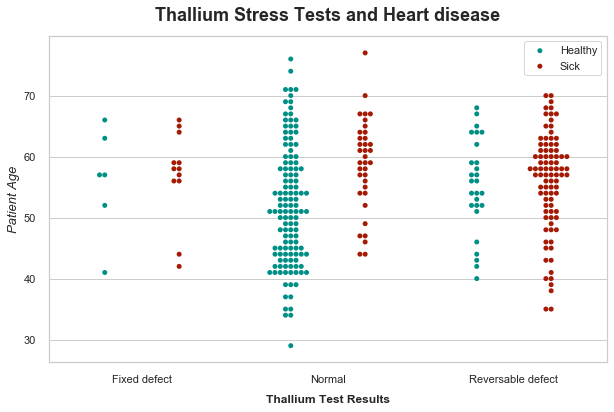

In [700]:
#set fig size
fig, ax = plt.subplots(figsize=(10,6))

#Plot swarm plot
g=sns.swarmplot(x='Thallium', y= 'Age', hue='Target', palette=disease,
                dodge=True,data=df)

#Set plot title
g.set_title('Thallium Stress Tests and Heart disease',pad = 15, fontsize=18, fontweight='bold')

#Set x label
g.set_xlabel('Thallium Test Results',labelpad=10, fontsize=12, fontweight='bold')

#Set ylabel
g.set_ylabel('Patient Age', fontsize=13, style = 'italic')

#Update Legend
g.legend(title='',frameon=True, loc='best', labels=['Healthy', 'Sick'])

Though not a 100% predictor, those with reversable defects in their hearts are very prone to heart disease. Interestingly enough, this stress test isn't enough to assess heart disease, with quite a few patients that had normal results still being diagnosed with heart disease.

Let's finally look at some EKG results, specifically in the context of the ST slope before we move onto building a classifier for our data.

**ST Slope and Heart Disease**

What is ST Depression?

ST depression refers to a finding on an electrocardiogram, wherein the trace in the ST segment is abnormally low below the baseline. The ST Segment represents the interval between ventricular depolarization and repolarization.

ST depression can be either upsloping, down sloping, or horizontal.**ST segment abnormality (elevation or depression) is myocardial ischemia or infarction**

More Specifics about ST Depression measurements:
- Horizontal or down sloping ST depression ≥ 0.5 mm at the J-point in ≥ 2 contiguous leads indicates myocardial ischemia. ST depression ≥ 1 mm is more specific and conveys a worse prognosis. 
- ST depression ≥ 2 mm in ≥ 3 leads is associated with a high probability of NSTEMI and predicts significant mortality (35% mortality at 30 days). 
- Upsloping ST depression is non-specific for myocardial ischemia.

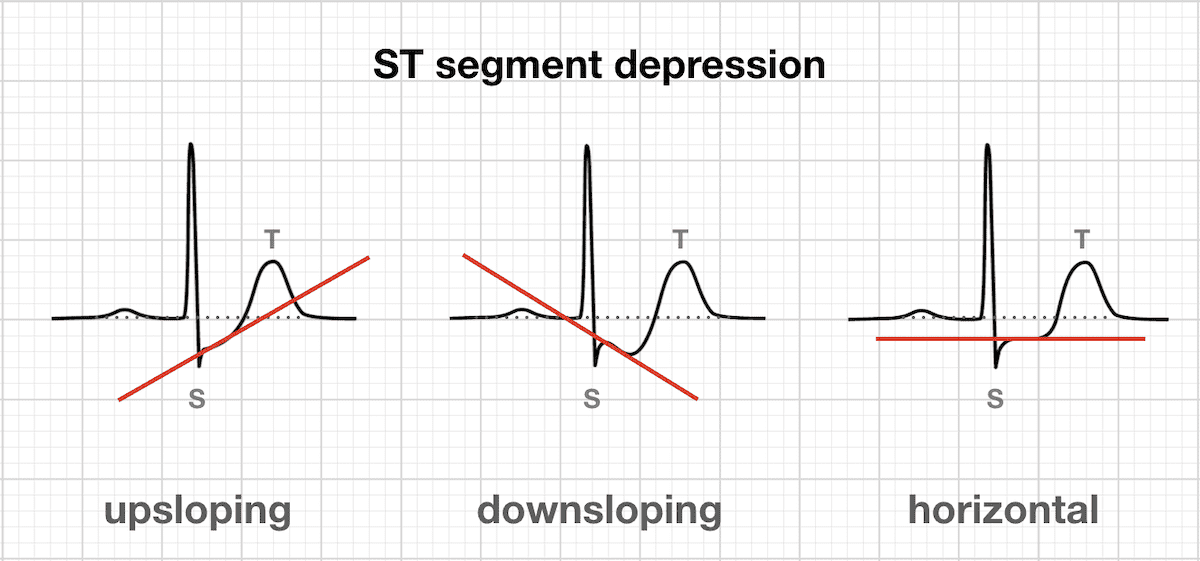

In [701]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename= "ST Slope.png", height=600, width =600)

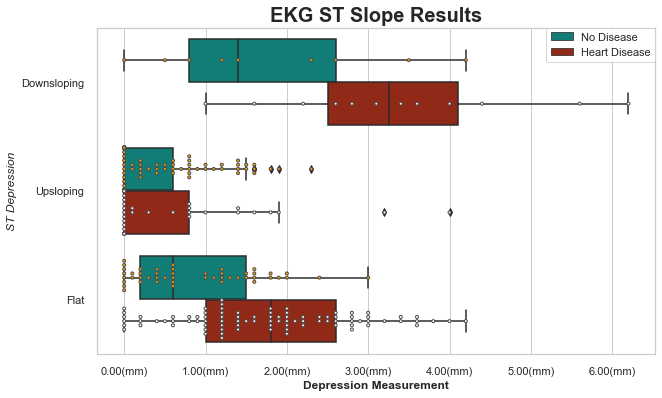

In [702]:
#Set Figure Size
fig, ax = plt.subplots(figsize = (10,6))

#Plot 
g=sns.boxplot('ST_Depression', 'ST_Slope', hue ='Target', palette= disease,
                data = df, ax=ax)

#Plot individual observations
j=sns.swarmplot(x="ST_Depression", y="ST_Slope", hue ='Target', data=df,
                  size=3, palette=['orange','#ffffff'],dodge=True, linewidth=1)

#Set x-label
g.set_xlabel('Depression Measurement', fontweight='bold', fontsize=12)

#Format x-ticks in mm
xlabels = ['{:,.2f}'.format(x) + '(mm)' for x in g.get_xticks()]
g.set_xticklabels(xlabels)

#Set y-label
g.set_ylabel('ST Depression', style ='italic', fontsize=12)

#Set title
g.set_title('EKG ST Slope Results', fontweight='bold', fontsize=20)

#Set Legend Labels. Get the handles and labels from boxemplot
handles, labels = g.get_legend_handles_labels()
labels = ['No Disease', 'Heart Disease']

#Create legend
l = g.legend(handles[0:2], labels[0:2],  loc='best', borderaxespad=0., frameon=True)

Not all too surprisingly, those with greater ST slope reduction were more likely to have heart disease.

Let's now move onto applying a model to our data to see if we can predict heart disease based on some of these relationships we have observed.This will allow us to get a better understanding overall of our dataset.

# Machine Learning

### Feature Engineering

Create dummy variables for categorical variables and check that all variables were correctly converted.

In [703]:
#Encode sex column 1=male, 0 = female
df.Sex = df.Sex.apply(lambda x: 1 if x=='Male' else 0)

#Create dummy variables for categorical variables
df = pd.get_dummies(df)

#Display all columns of df
pd.set_option('display.max_columns', 35)

#Check
df.head()

,Age,Sex,Rest_BP,Cholesterol,FBS_Over_120mg/dl,Max_HR,Exercise_Induced_Angina,ST_Depression,Num_Major_Vessels,Target,Chest_Pain_Asymptomatic,Chest_Pain_Atypical Angina,Chest_Pain_Non-anginal Pain,Chest_Pain_Typical Angina,Rest_EKG_Left ventricular hypertrophy,Rest_EKG_Normal,Rest_EKG_ST-T wave abnormality,ST_Slope_Downsloping,ST_Slope_Flat,ST_Slope_Upsloping,Thallium_Fixed defect,Thallium_Normal,Thallium_Reversable defect
0,63,1,145,233,1,150,0,2.3,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0
2,41,0,130,204,0,172,0,1.4,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0
3,56,1,120,236,0,178,0,0.8,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0
4,57,0,120,354,0,163,1,0.6,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0


In [704]:
#Missed Num_Major_Vessels
df = pd.get_dummies(df, columns=['Num_Major_Vessels'])

#Check
df.head()

,Age,Sex,Rest_BP,Cholesterol,FBS_Over_120mg/dl,Max_HR,Exercise_Induced_Angina,ST_Depression,Target,Chest_Pain_Asymptomatic,Chest_Pain_Atypical Angina,Chest_Pain_Non-anginal Pain,Chest_Pain_Typical Angina,Rest_EKG_Left ventricular hypertrophy,Rest_EKG_Normal,Rest_EKG_ST-T wave abnormality,ST_Slope_Downsloping,ST_Slope_Flat,ST_Slope_Upsloping,Thallium_Fixed defect,Thallium_Normal,Thallium_Reversable defect,Num_Major_Vessels_0,Num_Major_Vessels_1,Num_Major_Vessels_2,Num_Major_Vessels_3
0,63,1,145,233,1,150,0,2.3,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0
1,37,1,130,250,0,187,0,3.5,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0
2,41,0,130,204,0,172,0,1.4,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0
3,56,1,120,236,0,178,0,0.8,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,57,0,120,354,0,163,1,0.6,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0


**View Correlation Heatmap**

Check for collinearity between features.

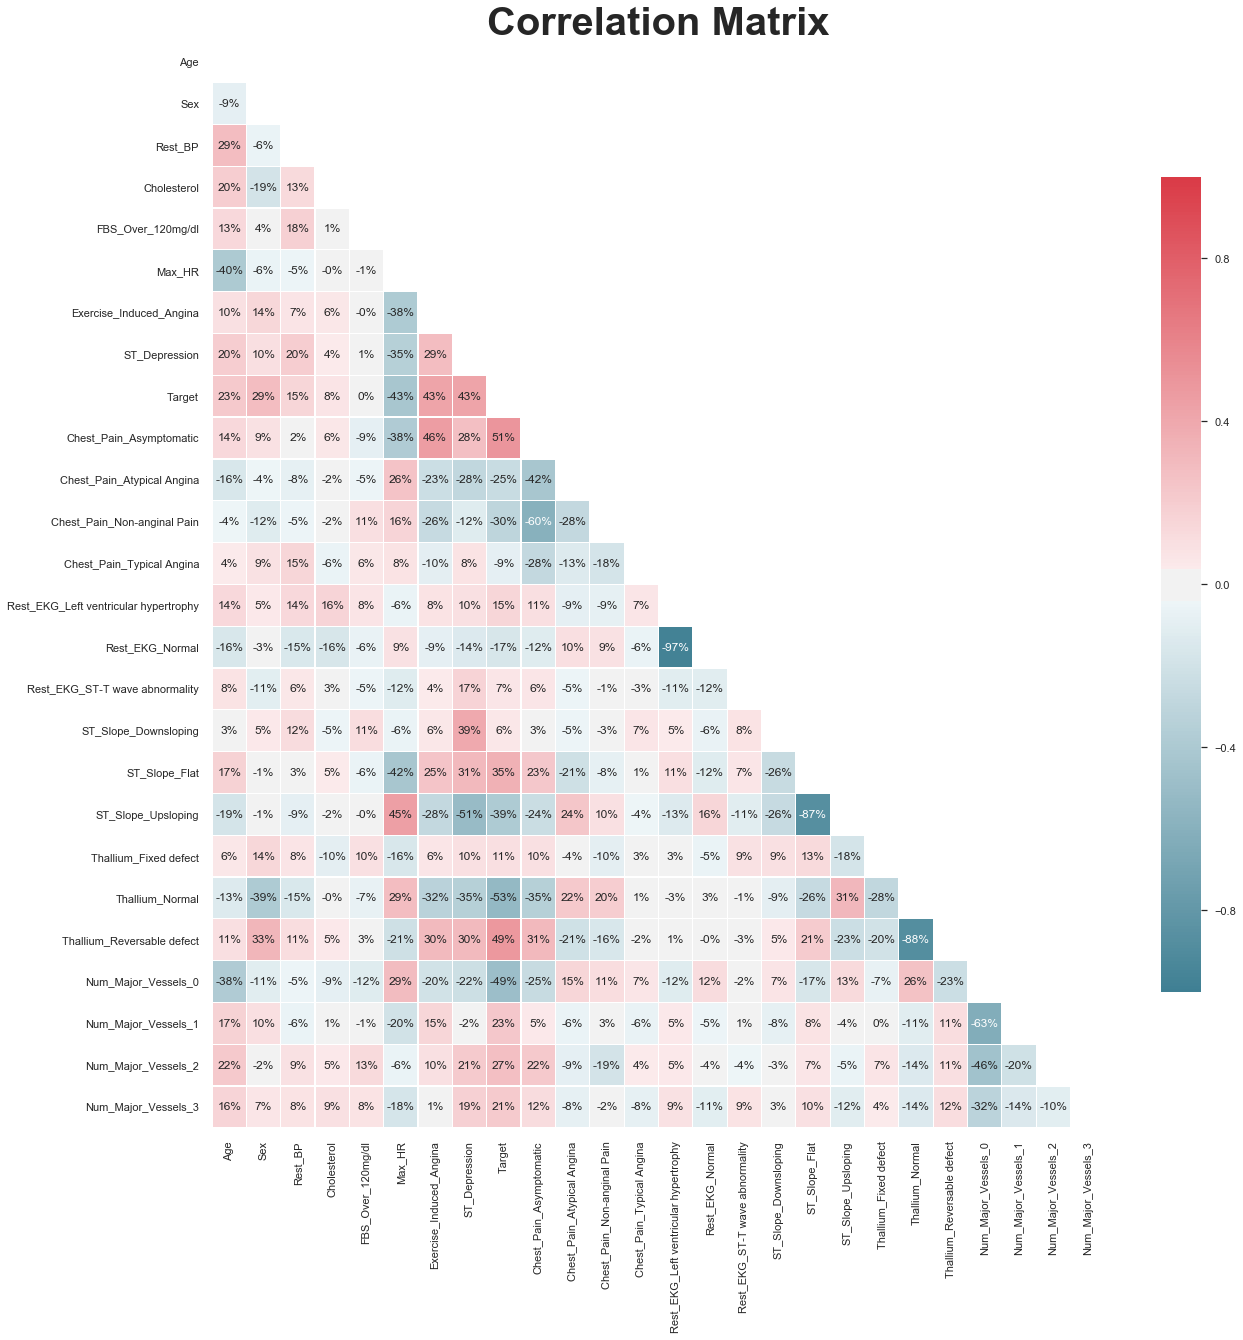

In [705]:
#Compute correlation matrix
corr = df.corr()

#Set figure size
fig, ax = plt.subplots(figsize=(20,20))

#Generate mask for upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

#Create custom cmap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Plot heatmap
g = sns.heatmap(corr, vmin=-1, vmax=1, center = 0,mask=mask,
               linewidth = .25, annot=True,fmt='.0%',
                cbar_kws={"shrink":.75},
               cmap= cmap, ax=ax)

#Set plot title
ax.set_title('Correlation Matrix', fontsize = 40, fontweight='heavy');

#Print correlation matrix to png file for reference
#plt.savefig("Correlation Matrix.png", dpi = 1080)

### Data Preprocessing

**View feature distributions** 

Cholesterol, Max_HR, Rest_BP, and ST_depression will each require transformations to achieve a more normal data distribution for our model.

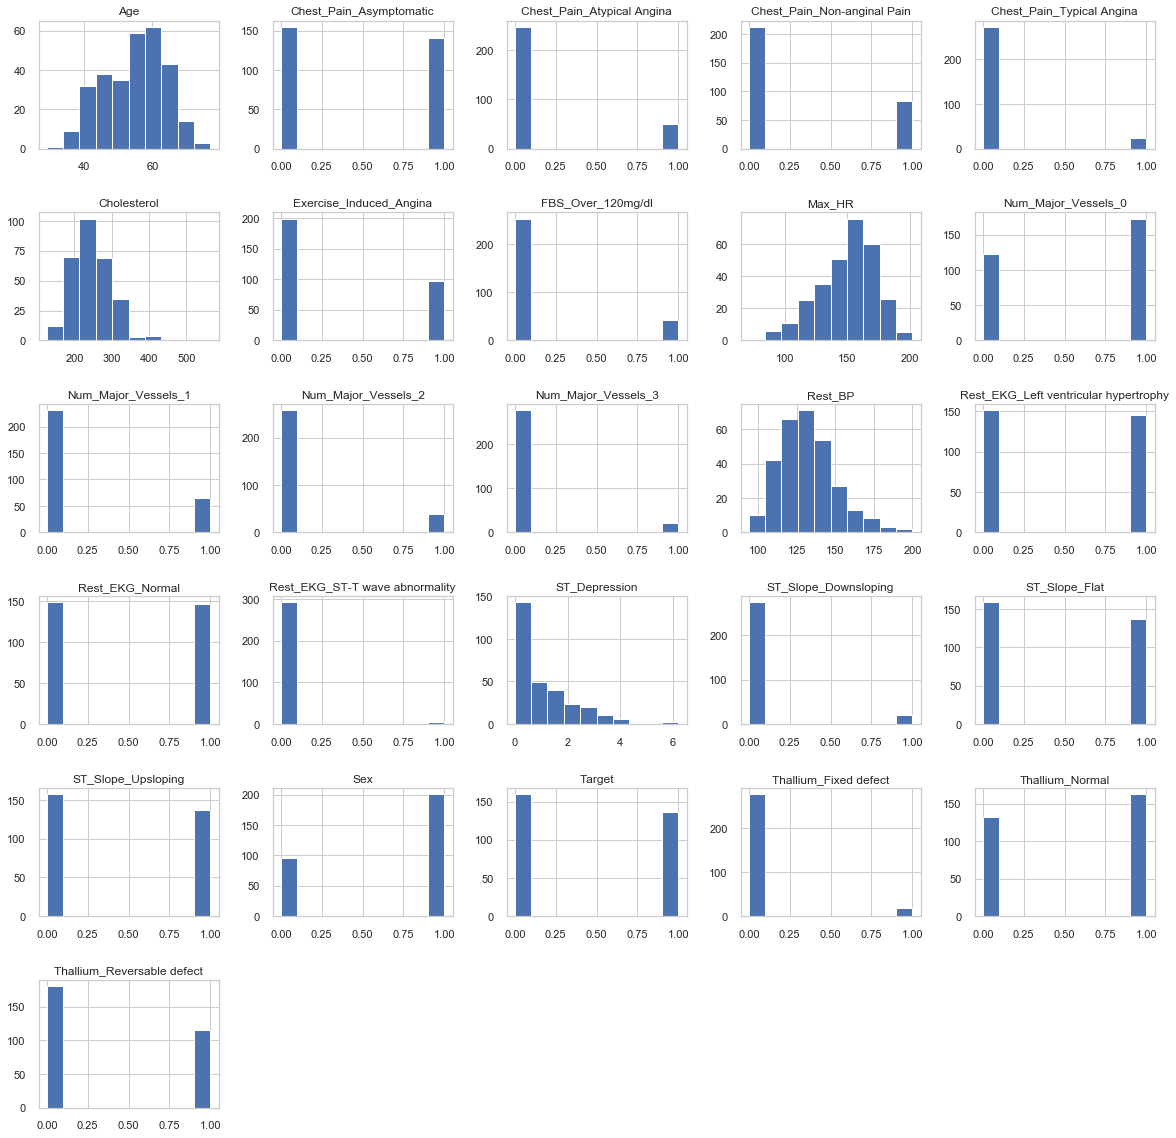

In [706]:
#Plot
df.hist(figsize=(20,20))

#Add space between subplots
plt.subplots_adjust(hspace=0.5);

Applying log transformations to ST_Depression, Rest_BP, and Cholesterol. Applying square transformation to Max_HR.

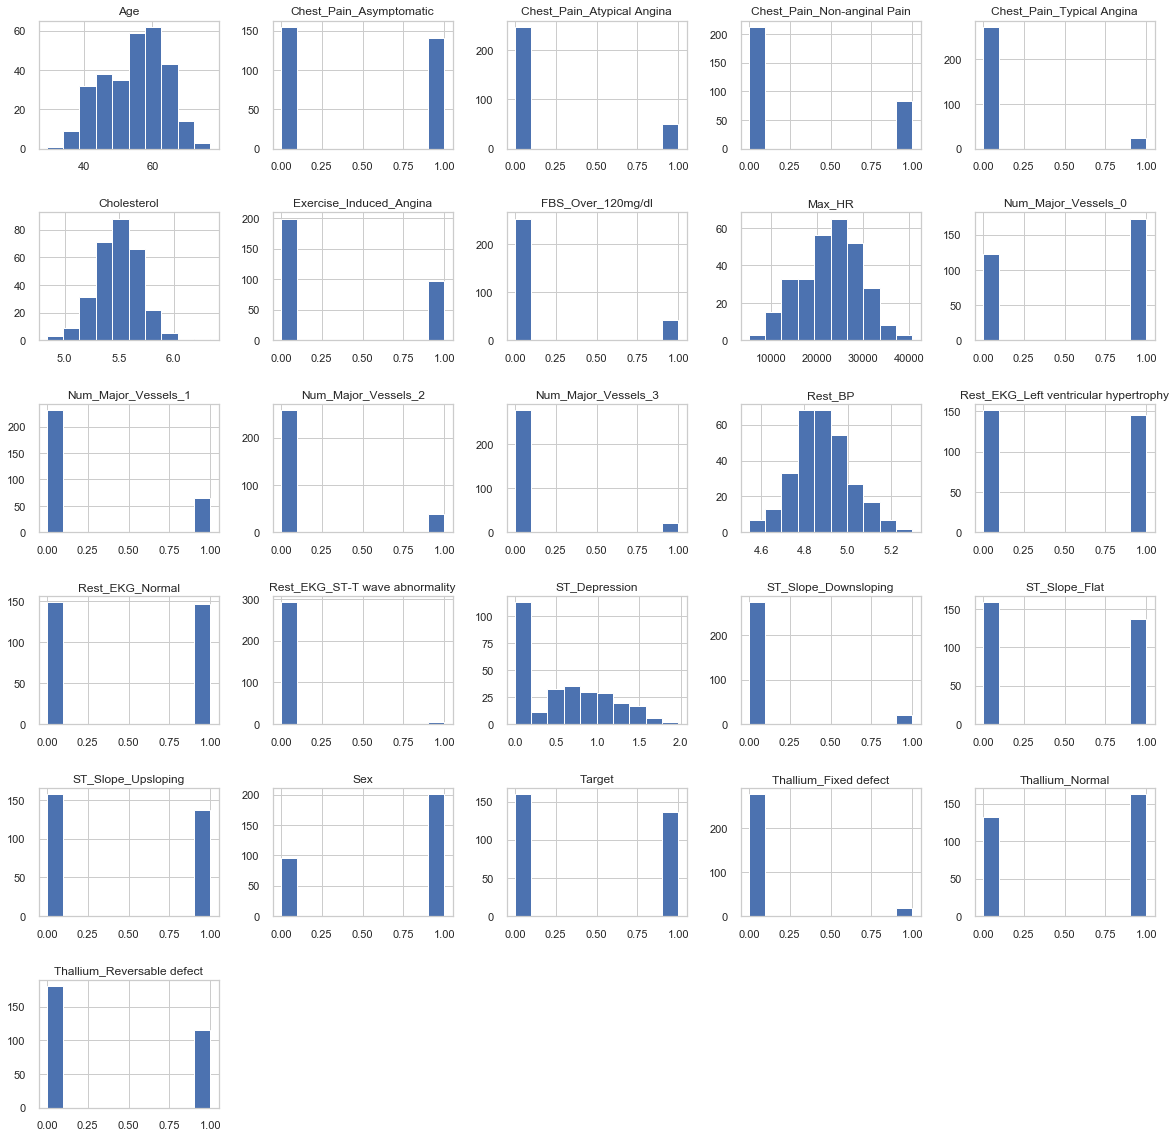

In [707]:
#Apply log transformations
df.ST_Depression = np.log(df.ST_Depression + 1)
df.Rest_BP = np.log(df.Rest_BP)
df.Cholesterol = np.log(df.Cholesterol)

#Apply square transformation
df.Max_HR= np.square(df.Max_HR)

#Plot
df.hist(figsize=(20,20))

#Add space between subplots
plt.subplots_adjust(hspace=0.5);

Data is in the appropriate distributions, we will now move on and prepare our data to apply our models to.

**Split Data**

In [708]:
#Seperate training/validation data from target. Convert into arrays
y= df.Target
X= df.drop(columns=['Target'])

#Import train test split
from sklearn.model_selection import train_test_split

#Split data
X_train, X_test, y_train, y_test = train_test_split(
                                X, y, stratify = y, random_state=0)

#Show the label distribution
print('Class distribution % for training/test sets')
print(y_train.value_counts(normalize=True) * 100)

#Confirm train and test data is in proper shapes
print('\nX_train shape: {} y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_test shape: {} y_test shape: {}'.format(X_test.shape, y_test.shape))

Class distribution % for training/test sets
0    54.054054
1    45.945946
Name: Target, dtype: float64

X_train shape: (222, 25) y_train shape: (222,)
X_test shape: (74, 25) y_test shape: (74,)


**Model Based Feature Selection**

Using a random forest classifier to select features with a feature importance greater than .025

In [709]:
#Import models
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

#Instantiae selector to remove features with less than a .025 feature importance
select = SelectFromModel(RandomForestClassifier(n_estimators=100,
                                           random_state = 42),
                                           threshold = .025)

#Fit select to training data
select.fit(X_train, y_train)

#Print Features kept by select
selected_feat= X_train.columns[(select.get_support())]
print(selected_feat)

#Transform X_train
X_train = select.transform(X_train)

#Confirm X_train Shape
print("Training data shape: {}".format(X_train.shape))

Index(['Age', 'Rest_BP', 'Cholesterol', 'Max_HR', 'Exercise_Induced_Angina',
       'ST_Depression', 'Chest_Pain_Asymptomatic',
       'Chest_Pain_Non-anginal Pain', 'ST_Slope_Flat', 'ST_Slope_Upsloping',
       'Thallium_Normal', 'Thallium_Reversable defect', 'Num_Major_Vessels_0'],
      dtype='object')
Training data shape: (222, 13)


We were able to reduce the number of features in our data from 25 to 13.

### Metrics for Classifier Evaluation

For our model, we want to make sure we are limiting the number of false negatives (identifying a sick person as healthy). Because our target is fairly balanced, we will evaluate different base classifiers using accuracy. Once we have identified the most accurate model, we will then proceed to optimize it's recall performance on the training and validation data before applying it to the test data.

# Create Pipeline of Base Classification models

We will use the following models to create a pipeline and select the model that performs best to tune.
- Logistic Regression
- KNN
- Decision Tree
- Random Forest
- Gradient Boosted Tree
- SVM(linear and rbf)

Building the pipeline

In [710]:
#Import pipeline
from sklearn.pipeline import Pipeline

#Import Scaler
from sklearn.preprocessing import StandardScaler

#Import cross validator to test accuracy of pipe
from sklearn.model_selection import cross_validate

In [711]:
#Summon base model for pipeline
from sklearn.linear_model import LogisticRegression

#Build Pipeline with LogisticRegression
pipe = Pipeline([
    ('normalizer', StandardScaler()), #Step1 - normalize data
    ('classifier', LogisticRegression()) #step2 - classifier
])
pipe.steps

[('normalizer', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('classifier',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False))]

In [712]:
#Evaluate pipeline using cross validate, using roc_auc to reduce # of false positives
scores = cross_validate(pipe, X_train, y_train, cv=5,
                        return_train_score=True, scoring="accuracy") #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

#Print all scores
print(str(classifier))
print('--------------------------------------------')
for key, values in scores.items():
        print(key,' mean ', values.mean())
        print(key,' std ', values.std())
#Results
print('Mean Test Fold Accuracy:',scores['test_score'].mean())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
--------------------------------------------
fit_time  mean  0.002193307876586914
fit_time  std  0.0007378722400594565
score_time  mean  0.0007987022399902344
score_time  std  0.00039949475737069054
test_score  mean  0.8690909090909091
test_score  std  0.03391503454828532
train_score  mean  0.8918809115723988
train_score  std  0.013618438168218587
Mean Test Fold Accuracy: 0.8690909090909091


86.9% is a really solid performance from our logistic regression model. Let's see how other classifiers do on this same data:

In [713]:
#Import additional classification base models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC

#Append classifiers to list to set as params for pipeline
classifier = []
classifier.append(KNeighborsClassifier())
classifier.append(DecisionTreeClassifier())
classifier.append(RandomForestClassifier())
classifier.append(GradientBoostingClassifier())
classifier.append(LinearSVC())
classifier.append(SVC())

In [714]:
#Score all base models
for classifier in classifier:
    pipe.set_params(classifier=classifier)
    scores = cross_validate(pipe, X_train, y_train,
                            cv=5, return_train_score=True, scoring="accuracy")
    print('--------------------------------------------')
    print(str(classifier))
    print('--------------------------------------------')
    for key, values in scores.items():
        print(key,' mean ', values.mean())
        print(key,' std ', values.std())
    print('Mean Test Fold Accuracy:',scores['test_score'].mean())


--------------------------------------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
--------------------------------------------
fit_time  mean  0.0029918670654296873
fit_time  std  0.002092146370151685
score_time  mean  0.003192615509033203
score_time  std  0.0015985138400215488
test_score  mean  0.8469696969696969
test_score  std  0.057331575061485174
train_score  mean  0.8828604075414207
train_score  std  0.014592644202688873
Mean Test Fold Accuracy: 0.8469696969696969
--------------------------------------------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0,

Of our base classifiers, logistic regression performed best with a accuracy of 86.9%. I am going to select LinearSVC() instead(accuracy is 86.46%) because it is a more complex that I think will generalize much better to our data.

**LinearSVC Optimization**

We will use RandomSearch CV to optimize our LinearSVC model for accuracy. We will then transition to optimizing it's recall performance by adjusting the threshold as needed.

In [715]:
#Instantiate LinearSVC
lsvc = LinearSVC(random_state=0)

#Print params of LinearSVC to optimize
print('Parameters currently in use for LinearSVC:')
print(lsvc.get_params)

Parameters currently in use for LinearSVC:
<bound method BaseEstimator.get_params of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=0)>


In [716]:
#Set random grid parameters to optimize

#Set C parameters
C = [.01,.1,1,10]

#Set dual parameters for optimization
dual = [True,False]

#Set max_iter parameters for optimization
max_iter = [400,500, 600, 700]

#Set penalty parameters for optimization
penalty = ['l1','l2']

#Create the random grid
random_grid = {'C': C,
               'dual': dual,
               'max_iter':max_iter,
               'penalty':penalty}

#Print random grid
print(random_grid)

{'C': [0.01, 0.1, 1, 10], 'dual': [True, False], 'max_iter': [400, 500, 600, 700], 'penalty': ['l1', 'l2']}


In [717]:
#Summon RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Instantiate RandomizedSearchCV and fit lsvc
rand_lsvc = RandomizedSearchCV(lsvc, param_distributions=random_grid, n_iter=100, random_state=0,
                               scoring= 'accuracy', verbose = 2, cv=5, error_score=0.0,
                                n_jobs=-1)

In [735]:
#Fit model to data
best_model = rand_lsvc.fit(X_train,y_train)

#Print best parameters found by the random search
print('Best parameters from RandomSearchCV:',best_model.best_params_)

#Score
print("\nThe mean accuracy of the model is:",best_model.score(X_train, y_train))

C:\Users\kishe\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 64 is smaller than n_iter=100. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s


LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=400,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=0)
Best parameters from RandomSearchCV: {'penalty': 'l2', 'max_iter': 400, 'dual': False, 'C': 0.1}

The mean accuracy of the model is: 0.8693693693693694


[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    3.6s finished


**Confusion Matrix**

In [733]:
#Import confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

#Store Predictions of RandomsearchCV
preds =best_model.predict(X_train)

#Instantiate and print Confusion Matrix 
confusion = confusion_matrix(y_train, preds)
print("Confusion Matrix: \n", confusion)
print('\nClassification Report:\n', classification_report(y_train, preds, 
                                                          target_names= ['Healthy', 'Sick']))

AttributeError: 'RandomizedSearchCV' object has no attribute 'coef_'

For our optimized model, we are presently at 83% for recall for our Sick target which is not very good. No matter, let's visualize the ROC curve of our model so we can see all the thresholds for our classifier. Then we can increase recall based upon what thresholds are available

**ROC Curve**

AUC: 86.67%
Recall: 83.33%


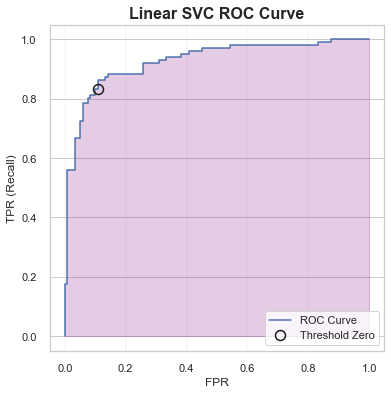

In [725]:
#Import ROC Curve and roc_auc_score
from sklearn.metrics import roc_auc_score,roc_curve, recall_score

#Calculate AUC Score
auc = roc_auc_score(y_train, preds)
print('AUC: {:.2%}'.format(auc))

#Calculate Recall Score
recall = recall_score(y_train, preds)
print('Recall: {:.2%}'.format(recall))

#Set false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_train, best_model.decision_function(X_train))

#Set Fig Size
fig, ax = plt.subplots(figsize=(6,6))

#Plot ROC Curve
plt.plot(fpr, tpr, label = 'ROC Curve')

#Set plot labels
plt.title('Linear SVC ROC Curve', fontweight='bold', fontsize=16)
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')

#Plot threshold closest to 0
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o',
       label= 'Threshold Zero', markersize=10, fillstyle= 'none', c = 'k', mew=1.5)

#Plot AUC 
plt.fill_between(fpr, tpr, step='post', alpha=0.2,
                     color='purple');

#Set Legend
plt.legend(loc = 'best', frameon=True)

#Set Gridlines
plt.grid(False,lw = .25, axis = 'x')

**Decrease Threshold to Increase Recall**

In [727]:
#Lower Decision Threshold to increase class 1 recall
pred_lower_threshold = best_model.decision_function(X_train) > -.75

recall = recall_score(y_train, pred_lower_threshold)
print('Recall w/ threshold set at -0.75: {:.2%}\n'.format(recall))

#View confusion matrix
confusion = confusion_matrix(y_train, pred_lower_threshold)
print("Confusion Matrix: \n", confusion)

#print classification report
print(classification_report(y_train, pred_lower_threshold, target_names= ['Healthy', 'Sick']))

Recall w/ threshold set at -.75: 98.04%

Confusion Matrix: 
 [[ 52  68]
 [  2 100]]
              precision    recall  f1-score   support

     Healthy       0.96      0.43      0.60       120
        Sick       0.60      0.98      0.74       102

    accuracy                           0.68       222
   macro avg       0.78      0.71      0.67       222
weighted avg       0.79      0.68      0.66       222



# Evaluate model


In [722]:
#Fit best model to test data
best_model.fit(X_test, y_test)

#Adjust decision function threshold
best_model_preds= best_model.decision_function(X_test) > -.75

#View confusion matrix
confusion = confusion_matrix(y_test, best_model_preds)
print("Confusion Matrix: \n", confusion)

#pring class report
print(classification_report(y_test, best_model_preds, target_names= ['Healthy', 'Sick']))

#Print Recall Statistics
recall = recall_score(y_test, best_model_preds)
print('Recall: {:.2%}'.format(recall))

#Print Accuracy (for funsies)
print("The mean accuracy of the model is:", best_model.score(X_test, y_test))


Conclusions

We were able to build a fantastic estimator using a LinearSVC model to maximize recall. This was a very interesting dataset to work on, I do wish that this data was not corrupted so we could make some concrete analysis about what we observed but no matter. We'll try anyway :)

ST slope depression seemed to be a very strong indicator of heart disease. Though there are some outliers, it appears that the best diagnosis for diagnosing heart disease is through the use of an EKG

With that said, additional information about the patients would have been nice so we can see how lifestyle plays into heart disease. For example, some really useful information to have for this analysis would have been patient BMI, activity level, and diet. Lifestyle may help explain why there were some extreme outliers without heart disease in some cases.

Though this was a pretty simple dataset, I had a lot of fun testing out my machine learning knowledge and have a greater understanding of the concepts. On to the next!
